In [1]:
import numpy as np, tqdm, pickle 
from matplotlib import pyplot as plt
from GIF_Saver import *

plt.rcParams['figure.dpi'] = 100

In [2]:
"""
 (0, 0)------->
   |          x
   |
   |
   V y
"""
pass

In [3]:
def draw_bodies(body_map):
    """
    Draws LBM Rigid body map using plt.imshow

    parameters:
        body_map (np.array)
    """
    
    plt.imshow(body_map, cmap = 'Greys', interpolation='none')
    plt.xlabel('x cell', fontsize = 9)
    plt.ylabel('y cell', fontsize = 9)
    plt.show()

In [4]:
def equi_state(ux, uy, rho, e, c, w):
    """
    Computes F-function equilibrium state for current configuration

    parameters:
        ux (np.array)
        uy (np.array)
        rho (np.array) - density
        e (np.array)   - lattice direction vectors
    
    returns:    
        np.array 9*Nx*Ny
    """

    Nx, Ny = ux.shape
    u_proj = np.zeros((9, Nx, Ny))

    for i in range(9):
        u_proj[i] = (ux*e[i,0] + uy*e[i,1])/c**2 

    f_equi = np.zeros_like(u_proj)
    u_2    = (ux**2 + uy**2) / c**2

    for i in range(9):
        f_equi[i] = rho * w[i] * (1 + u_proj[i] + u_proj[i]**2/2 - u_2/2)
    
    return f_equi

In [ ]:
def iter_step(f, f_ini, bodies, ux, uy, rho, visc, e, c, w, opposites):
    """
    Performs LBM simulation step 

    parameters:
        f (np.array)      - dist function
        f_ini (np.array)
        bodies (np.array) - obstacles array
        ux (np.array) 
        uy (np.array) 
        rho (np.array) 
        visc (float) - viscosity parameter
        e (np.array) - lattice speed direction
        c (float)    - lattice sound speed 
        w (np.array) - lattice weights
        opposites (list) - opposite directions list

    returns:
        ux, uy, rho, f (np.array) 
    """

    Nx, Ny = rho.shape
    
    # Streaming
    (fNW, fN, fNE, fW, fC, fE, fSW, fS, fSE) = f

    for y in range(Nx-1,0,-1):
        fN[y]  = fN[y-1]
        fNE[y] = fNE[y-1]
        fNW[y] = fNW[y-1]

    for y in range(0,Nx-1):
        fS[y]  = fS[y+1]
        fSE[y] = fSE[y+1]
        fSW[y] = fSW[y+1]

    for x in range(Ny-1,0,-1):
        fE[:,x]  = fE[:,x-1]
        fNE[:,x] = fNE[:,x-1]
        fSE[:,x] = fSE[:,x-1]

    for x in range(0,Ny-1):
        fW[:,x]  = fW[:,x+1]
        fNW[:,x] = fNW[:,x+1]
        fSW[:,x] = fSW[:,x+1]
    

    # Obstacles BC
    for i in range(9):
        f[i, np.roll(bodies, shift = e[i], axis = (0,1))] = f[opposites[i], np.roll(bodies, shift = e[i], axis = (0,1))]

    # New density and velocity
    rho = np.sum(f, axis = 0)

    ux = np.zeros_like(rho)
    uy = np.zeros_like(rho)

    for i in range(9):
        ux += f[i] * e[i, 0]
        uy += f[i] * e[i, 1]

    ux /= rho 
    uy /= rho
    
    # Collision step 
    f = f + (equi_state(ux, uy, rho, e, c ,w) - f) / (1/2 + visc/c**2)

    # Inlet & Outlet BC:
    f[:, 0, :] = f_ini[:, 0, :]
    f[:,-1, :] = f_ini[:,-1, :]
    f[:, :, 0] = f_ini[:, :, 0]
    f[:, :,-1] = f_ini[:, :,-1]

    return ux, uy, rho, f

In [6]:
""" 
Lattice parameters
"""

c = 1/np.sqrt(3)

w = np.array([
    1/36, 1/9, 1/36,
    1/9,  4/9, 1/9,
    1/36, 1/9, 1/36
])

e = np.array([
    [-1, 1],[ 0, 1],[ 1, 1],
    [-1, 0],[ 0, 0],[ 1, 0],
    [-1,-1],[ 0,-1],[ 1,-1]
])

opposites = list(range(9))[::-1]

In [7]:
""" 
Simulation parameters
"""

visc = 1e-2
Nx   = 200
Ny   = 80

n_iter = 3000 

In [8]:
"""
Arrays initialization
"""

u0 = np.array([0.00, 0.15])

ux = np.ones((Nx, Ny)) * u0[0]
uy = np.ones((Nx, Ny)) * u0[1]

rho = np.ones((Nx, Ny))

f  = equi_state(ux, uy, rho, e, c, w)
f_ini = f.copy()

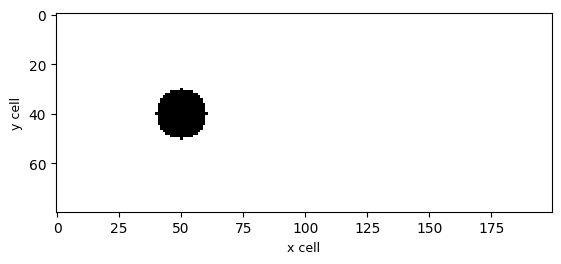

In [9]:
"""
Bodies initialization
"""

body_map = np.zeros((Nx, Ny)).astype(np.bool)

# Adding cylinder
cx = Nx//4
cy = Ny//2 
r  = Ny//8
X,Y = np.meshgrid(np.arange(Nx), np.arange(Ny), indexing='ij')
R2  = (X - cx)**2 + (Y - cy)**2

body_map[R2 <= r**2] = True

draw_bodies(body_map.T)

In [10]:
"""
LBM Simulation
"""

u_hist     = [ ]
unorm_hist = [ ]
curl_hist  = [ ]

for i_step in tqdm.tqdm(range(n_iter)):
    ux, uy, rho, f = iter_step(f, f_ini, body_map, ux, uy, rho, visc, e, c, w, opposites)

    u_hist.append([ux, uy])
    #unorm_hist.append(np.roll(uy,-1,axis=1) - np.roll(uy,1,axis=1) - np.roll(ux,-1,axis=0) + np.roll(ux,1,axis=0))
    unorm_hist.append(np.sqrt(ux**2 + uy**2))
    curl = np.gradient(ux, 1, axis=0) - np.gradient(uy, 1, axis=1)
    curl[body_map] = np.nan
    curl_hist.append(curl.copy())

100%|██████████| 3000/3000 [00:14<00:00, 210.42it/s]


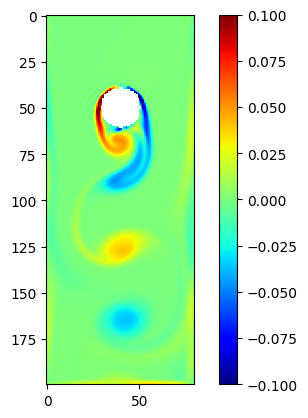

In [11]:
plt.imshow(curl_hist[-1], cmap = 'jet', vmin = -0.1, vmax = 0.1)
plt.colorbar()
plt.show()

In [14]:
save_GIF(curl_hist[::15], interval=45, cmap_ = 'RdYlGn', output_file='animation_3.gif')